In [1]:
import warnings
from pathlib import Path
import os
import pandas as pd
import tqdm
import random
import pickle

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.wyscout import PublicWyscoutLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier as XGBc
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

# Preprocessing

In [2]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [3]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [4]:
comp = ['Italy']
selected_competitions = competitions[(competitions['country_name'] =='Italy')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,524,181248,Italy,Italian first division,male,2017/2018


### Retrieve the scoreline of a game

In [5]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20 18:45:00,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524


In [6]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181248,2576335,"Lazio - Internazionale, 2 - 3",524,2,3
1,181248,2576336,"Sassuolo - Roma, 0 - 1",524,0,1
2,181248,2576329,"Cagliari - Atalanta, 1 - 0",524,1,0
3,181248,2576330,"Chievo - Benevento, 1 - 0",524,1,0
4,181248,2576331,"Udinese - Bologna, 1 - 0",524,1,0


In [7]:
# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,2576335,524,181248,2018-05-20 18:45:00,38,3162,3161,2,3
1,2576336,524,181248,2018-05-20 18:45:00,38,3315,3158,0,1
2,2576329,524,181248,2018-05-20 16:00:00,38,3173,3172,1,0
3,2576330,524,181248,2018-05-20 16:00:00,38,3165,3219,1,0
4,2576331,524,181248,2018-05-20 16:00:00,38,3163,3166,1,0


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


# SPADL

In [9]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ita"

In [10]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [11]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3162,Lazio,SS Lazio
1,3161,Internazionale,FC Internazionale Milano
2,3158,Roma,AS Roma
3,3315,Sassuolo,US Sassuolo Calcio
4,3173,Cagliari,Cagliari Calcio
5,3172,Atalanta,Atalanta Bergamasca Calcio
6,3165,Chievo,AC Chievo Verona
7,3219,Benevento,Benevento Calcio
8,3166,Bologna,Bologna FC 1909
9,3163,Udinese,Udinese Calcio


In [12]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Internazionale vs Milan game 
    game = games[(games.country_name == "Italy") 
                  & (games.home_team_name_short == "Internazionale")
                  & (games.away_team_name_short== "Milan")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2576034,196692208,0,1,2.532778,3157,135927,51.45,32.64,16.8,7.48,0,0,pass,foot,André Silva,Milan,AC Milan
1,2576034,196692208,1,1,3.325886,3157,37732,68.25,40.12,0.0,0.00,23,0,receival,foot,L. Biglia,Milan,AC Milan
2,2576034,196692209,2,1,4.118994,3157,37732,68.25,40.12,-10.5,15.64,0,0,pass,foot,L. Biglia,Milan,AC Milan
3,2576034,196692209,3,1,5.348591,3157,285109,57.75,55.76,0.0,0.00,23,0,receival,foot,F. Kessié,Milan,AC Milan
4,2576034,196692210,4,1,6.578187,3157,285109,57.75,55.76,-12.6,10.88,0,0,pass,foot,F. Kessié,Milan,AC Milan


2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , M. Icardi 62'


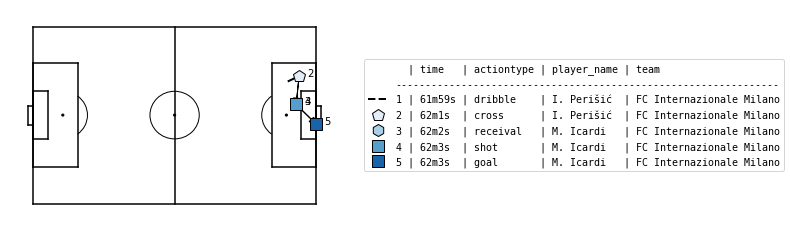

In [13]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-4:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [14]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [15]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [16]:
#Example of final framework
print('Features')
display( pd.HDFStore(features_h5)["game_2576034"].head()) #With lags -1,-2.
print('Labels')
display(pd.HDFStore(labels_h5)["game_2576034"].head())

Features


,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,2.532778,2.532778,1,2.532778,2.532778,1,2.532778,2.532778,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,3.325886,3.325886,1,2.532778,2.532778,1,2.532778,2.532778,0.793108,0.793108
2,0,23,0,True,False,False,False,False,False,False,...,4.118994,4.118994,1,3.325886,3.325886,1,2.532778,2.532778,0.793108,1.586216
3,23,0,23,False,False,False,False,False,False,False,...,5.348591,5.348591,1,4.118994,4.118994,1,3.325886,3.325886,1.229597,2.022705
4,0,23,0,True,False,False,False,False,False,False,...,6.578187,6.578187,1,5.348591,5.348591,1,4.118994,4.118994,1.229597,2.459193


Labels


,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [17]:
#Labels
#goal = True if goal from a shot
#Score = True if within next 10 actions goal
#concedes = True if within next 10 actions goal

### Predictions

In [18]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [19]:
# 1. Select feature set X
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.movement_polar,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3
Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"): #aggiungi azioni di ogni partita
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [20]:
#Load  the trained model 
model = pickle.load(open('trained_model.sav', 'rb'))

In [21]:
#Prediction for all games
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:06<00:00, 62.86it/s] 


In [22]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):    #azioni per ogni partita del test
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:08<00:00, 43.30it/s]


## VAEP

In [23]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [24]:
#For each game in the test set, append the predictions and compute vaep
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:26<00:00, 14.39it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [25]:
#Retrieve roles for each player
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

In [27]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#Add the last team for which the player has played
playersR = playersR.merge(A[["player_id","team_name_short"]].groupby('player_id').tail(1), on = 'player_id')
# Add player name
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "team_name_short","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,team_name_short,vaep_value,offensive_value,defensive_value,count
182,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536
374,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310
192,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161
3,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668
104,20633,S. Sorrentino,Goalkeeper,Chievo,25.157254,1.600248,23.557006,1990
37,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198
13,3323,G. Higuaín,Forward,Juventus,24.947571,23.778553,1.169018,2047
197,21494,A. Cordaz,Goalkeeper,Crotone,24.447464,2.236261,22.211202,1994
319,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250
43,14812,I. Perišić,Midfielder,Internazionale,21.836799,19.833861,2.002938,4074


In [31]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats.rename(columns={'team_name_short':'Team'}, inplace = True)
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played

#save results
#filename = 'players_ita.sav'
#pickle.dump(stats, open(filename, 'wb'))

In [35]:
stats = pickle.load(open('players_ita.sav', 'rb'))
stats = stats[stats.minutes_played > 1710] # at least 19 full games played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
191,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161,2816,0.950671,0.949197,0.001474
181,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536,3429,0.871165,0.055181,0.815984
373,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310,3103,0.867056,0.840969,0.026087
318,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250,2491,0.802730,0.783205,0.019525
2,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668,3142,0.777514,0.764027,0.013487
12,3323,G. Higuaín,Forward,Juventus,24.947571,23.778553,1.169018,2047,2977,0.754209,0.718868,0.035341
36,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198,3177,0.709879,0.665603,0.044276
458,333913,K. Lasagna,Forward,Udinese,17.465562,17.256119,0.209442,1273,2253,0.697692,0.689326,0.008367
17,3484,Luis Alberto,Midfielder,Lazio,21.669055,20.203749,1.465306,4107,2805,0.695264,0.648249,0.047015
312,86243,D. Zapata,Forward,Sampdoria,16.953640,15.684469,1.269171,1562,2227,0.685149,0.633858,0.051291


In [36]:
stats[stats.Role == "Forward"].sort_values('vaep_rating', ascending = False)[:5].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,C. Immobile,Forward,Lazio,0.950671
1,M. Icardi,Forward,Internazionale,0.867056
2,P. Dybala,Forward,Juventus,0.802730
3,D. Mertens,Forward,Napoli,0.777514
4,G. Higuaín,Forward,Juventus,0.754209


In [37]:
stats[stats.Role == "Defender"].sort_values('vaep_rating', ascending = False)[:5].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,K. Koulibaly,Defender,Napoli,0.382164
1,A. Masiello,Defender,Atalanta,0.367334
2,João Cancelo,Defender,Internazionale,0.362600
3,Alex Sandro,Defender,Juventus,0.362318
4,S. Widmer,Defender,Udinese,0.354865


# Salary

In [38]:
#Upload salaries data
ita = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/serie-a/2017-2018/Seriea2.xlsx')
ita = ita[ita['Annual Gross(IN EUR)']>0] #Consider only available data
ita = ita.drop_duplicates(subset=["Player"], keep='last')  #Drop duplicates for player who transfered within the season
ita.drop('Unnamed: 0', axis = 1, inplace = True) #Drop column
#Retrieve player full name and surname
ita['Name'] = [ita['Player'][i-1:i].values[0].split()[0] for i in range(1,len(ita.Player)+1)]
ita['Surname'] = [ita['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(ita.Player)+1)]

In [39]:
#Retrieve player full name and surname
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
#giocatori = giocatori[giocatori['minutes_played']>1710]

#Merge players' stats and salary based on surname,name. Those players not matched due to language barriers were manually added by including their WyID in the salary data.
df = pd.merge(giocatori,ita, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,ita, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1)
#Create VAEP/Salary
df['vaep/salary'] = df['Salary'] / df['vaep_value'] 
display(df[(df['Role']=='Defender')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())
display(df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Defender,27.285714,6.339058,3.538165,2.800893,3286.650794,2547.269841,0.221176,1.841762e+06,309032.699321


,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,26.585366,14.07636,13.324374,0.751986,2260.97561,2506.829268,0.489286,3.285049e+06,230738.293691


In [40]:
df.groupby('Role').agg(['mean']).iloc[:2][['vaep_value','vaep_rating','Salary','vaep/salary']].round(4)

,vaep_value,vaep_rating,Salary,vaep/salary
,mean,mean,mean,mean
Role,,,,
Defender,6.3391,0.2212,1.841762e+06,309032.6993
Forward,14.0764,0.4893,3.285049e+06,230738.2937


### TOP 11

In [42]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = True)[:1]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = True)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = True)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = True)[:5]

top_11 = gk.append(dif).append(cen).append(att)
#top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11 = top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]
top_11.loc[:,'vaep_rating':] = top_11.loc[:,'vaep_rating':].round(4)
order = ['Goalkeeper','Defender','Midfielder','Forward']
top_11["Role"] = pd.Categorical(top_11["Role"], categories=order, ordered=True)
n = {'Goalkeeper':1, 'Defender':4,'Midfielder':3, 'Forward':3}
top_11 = top_11.groupby('Role').apply(lambda x: x.sort_values("vaep_rating", ascending=False)).drop('Role', axis = 1).reset_index()
top_11 = top_11.groupby('Role').apply(lambda x: x.head(n[x.name])).drop('level_1', axis = 1).reset_index(drop=True)
top_11.index =top_11.index +1
top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,minutes_played,vaep_value,Salary,vaep/salary
1,Nícolas,29.0,Goalkeeper,Hellas Verona,0.8712,3429,33.1914,458000.0,13798.7532
2,Fabrizio Cacciatore,30.0,Defender,Chievo,0.2965,3035,9.9989,550000.0,55005.8129
3,Bruno Martella,24.0,Defender,Crotone,0.2943,2777,9.0801,458000.0,50439.7303
4,Lorenzo Venuti,22.0,Defender,Benevento,0.2648,2554,7.5134,183000.0,24356.3326
5,Cristiano Biraghi,24.0,Defender,Fiorentina,0.2582,3166,9.0816,395000.0,43494.4885
6,Remo Freuler,25.0,Midfielder,Atalanta,0.4419,3189,15.6594,916000.0,58495.3218
7,Federico Chiesa,19.0,Midfielder,Fiorentina,0.4075,3190,14.4436,721000.0,49918.3523
8,Nicolò Barella,20.0,Midfielder,Cagliari,0.3039,3143,10.6133,549000.0,51727.5098
9,Kevin Lasagna,24.0,Forward,Udinese,0.6977,2253,17.4656,824000.0,47178.5575
10,Roberto Inglese,25.0,Forward,Chievo,0.5220,2928,16.9810,367000.0,21612.3395


In [43]:
print("Average salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].mean()))),"€")
print("Median salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].median()))),"€")
print("Salary per Top_11: " + ('{:,}'.format(int(top_11.Salary.sum()))+ "€"))

Average salary per Team(~starting 11)):  23,208,550 €
Median salary per Team(~starting 11)):  12,544,000 €
Salary per Top_11: 5,971,000€


### Data for Latex

In [44]:
d = df[df['Role']=='Defender'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal.loc[:,'vaep_rating':] = sal.loc[:,'vaep_rating':].round(4)
sal

,Player,Age,Role,Team,vaep_rating,vaep_value,Salary,vaep/salary
0,Kalidou Koulibaly,26.0,Defender,Napoli,0.3822,13.7027,"3,665,000",267465.4906
1,Andrea Masiello,31.0,Defender,Atalanta,0.3673,11.7261,"916,000",78116.2962
2,João Cancelo,23.0,Defender,Internazionale,0.3626,7.9289,"3,665,000",462235.6180
3,Alex Sandro,26.0,Defender,Juventus,0.3623,9.0177,"5,131,000",568992.1895
4,Silvan Widmer,24.0,Defender,Udinese,0.3549,6.8134,"916,000",134440.8108
0,Ciro Immobile,27.0,Forward,Lazio,0.9507,29.7454,"4,584,000",154107.6630
1,Mauro Icardi,24.0,Forward,Internazionale,0.8671,29.8942,"8,246,000",275839.8536
2,Paulo Dybala,23.0,Forward,Juventus,0.8027,22.2178,"12,827,000",577330.1053
3,Dries Mertens,30.0,Forward,Napoli,0.7775,27.1439,"6,419,000",236480.6053
4,Gonzalo Higuaín,29.0,Forward,Juventus,0.7542,24.9476,"13,744,000",550915.3590


Closing remaining open files:/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_labels.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Ita/atomic_spadl-wysco

2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , Mauro Emanuel Icardi Rivero  27


/Users/leonardoyang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value


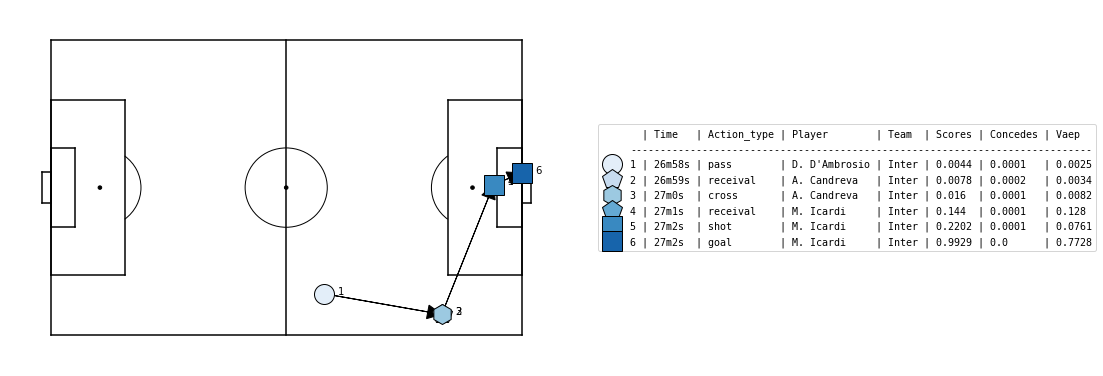

In [64]:
#For each game in the test set, append the predictions and compute vaep
B = []
actions = pd.HDFStore(spadl_h5) [f"actions/game_2576034"]
actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
)
preds = pd.HDFStore(predictions_h5) [f"game_2576034"]
values = vaepformula.value(actions, preds.scores, preds.concedes)
B.append(pd.concat([actions, preds, values], axis=1))

B = pd.concat(B).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
B['scores'] = B['scores'].round(decimals = 4)
B['concedes'] = B['concedes'].round(decimals = 4)
B['vaep_value'] = B['vaep_value'].round(decimals = 4)

#Plot
a = B.copy()
#Actions.type_name
pos = a[a.type_name == 'goal' ][0:1].action_id.values[0]
a = a[pos-5 : pos+1].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

game = games[(games.country_name == "Italy") & (games.home_team_name_short == "Internazionale") & (games.away_team_name_short== "Milan")]
g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name_short",'scores','concedes','vaep_value']]
labels[['team_name_short']] = 'Inter'
#labels.iloc[-1:,4:5] = 1
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["Time", "Action_type", "Player", "Team",'Scores','Concedes','Vaep'],
    zoom=False,
    figsize=10
)

In [121]:
#Icardi + 0.95 per 1 gol